In [4]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING  --disable_caching ndw_bernoulli_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s ndw_bernoulli_Scene"

In [61]:
background_color = "#20455A"

In [ ]:
class BernoulliTube(Mobject):
    def __init__(self, tube_center = np.array([-2, -1.5, 0]), **kwargs):
        super().__init__(**kwargs)

        self.center = tube_center
        tube_height = 1
        tube_width = 2
        tube_line_width = 4
        tube_color = WHITE

        # define main drift tube coordinates
        self.up_left = self.center + tube_height*UP + tube_width*2*LEFT
        self.up_mid_left = self.center + tube_height*UP + tube_width*LEFT
        self.up_mid_right = self.center + tube_height/4*UP + tube_width/2*LEFT
        self.up_right = self.center + tube_height/4*UP + tube_width/2*RIGHT

        self.down_left = self.center + tube_height*DOWN + tube_width*2*LEFT
        self.down_mid_left = self.center + tube_height*DOWN + tube_width*LEFT
        self.down_mid_right = self.center + tube_height/4*DOWN + tube_width/2*LEFT
        self.down_right = self.center + tube_height/4*DOWN + tube_width/2*RIGHT

        # bernoulli tube main lines
        tube_tunnel_up = Line(start = self.up_mid_right, end = self.up_right, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_tunnel_down = Line(start = self.down_mid_right, end = self.down_right, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_funnel_up = Line(start = self.up_mid_left, end = self.up_mid_right, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_funnel_down = Line(start = self.down_mid_left, end = self.down_mid_right, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_tunnel_up_left = Line(start = self.up_mid_left, end = self.up_left, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_tunnel_down_left = Line(start = self.down_mid_left, end = self.down_left, stroke_color = tube_color, stroke_width = tube_line_width)

        # bernoulli tube background
        polygon_corner_list = [
            self.up_left,
            self.up_mid_left,
            self.up_mid_right,
            self.up_right,
            self.down_right,
            self.down_mid_right,
            self.down_mid_left,
            self.down_left
        ]
        tube_background_polygon = Polygon(*polygon_corner_list, fill_color = WHITE, fill_opacity = 1, stroke_opacity = 0, stroke_width = tube_line_width)
        tube_polygon = Polygon(*polygon_corner_list, fill_color = BLUE, fill_opacity = 0.25, stroke_opacity = 0, stroke_width = tube_line_width)
        self.add(tube_background_polygon, tube_polygon)
        self.add(tube_tunnel_up, tube_tunnel_down, tube_funnel_up, tube_funnel_down, tube_tunnel_up_left, tube_tunnel_down_left)


    # trajectory of a fluid particle with t in [0, 1] and starting height
    def bernoulli_tube_trajectory(t):
        return
            

    def get_counter(n):
        return


class DoorHallway(Mobject):
    def __init__(self, hallway_center = np.array([2, -1.5, 0]), **kwargs):
        super().__init__(**kwargs)

Manim Community v0.18.1

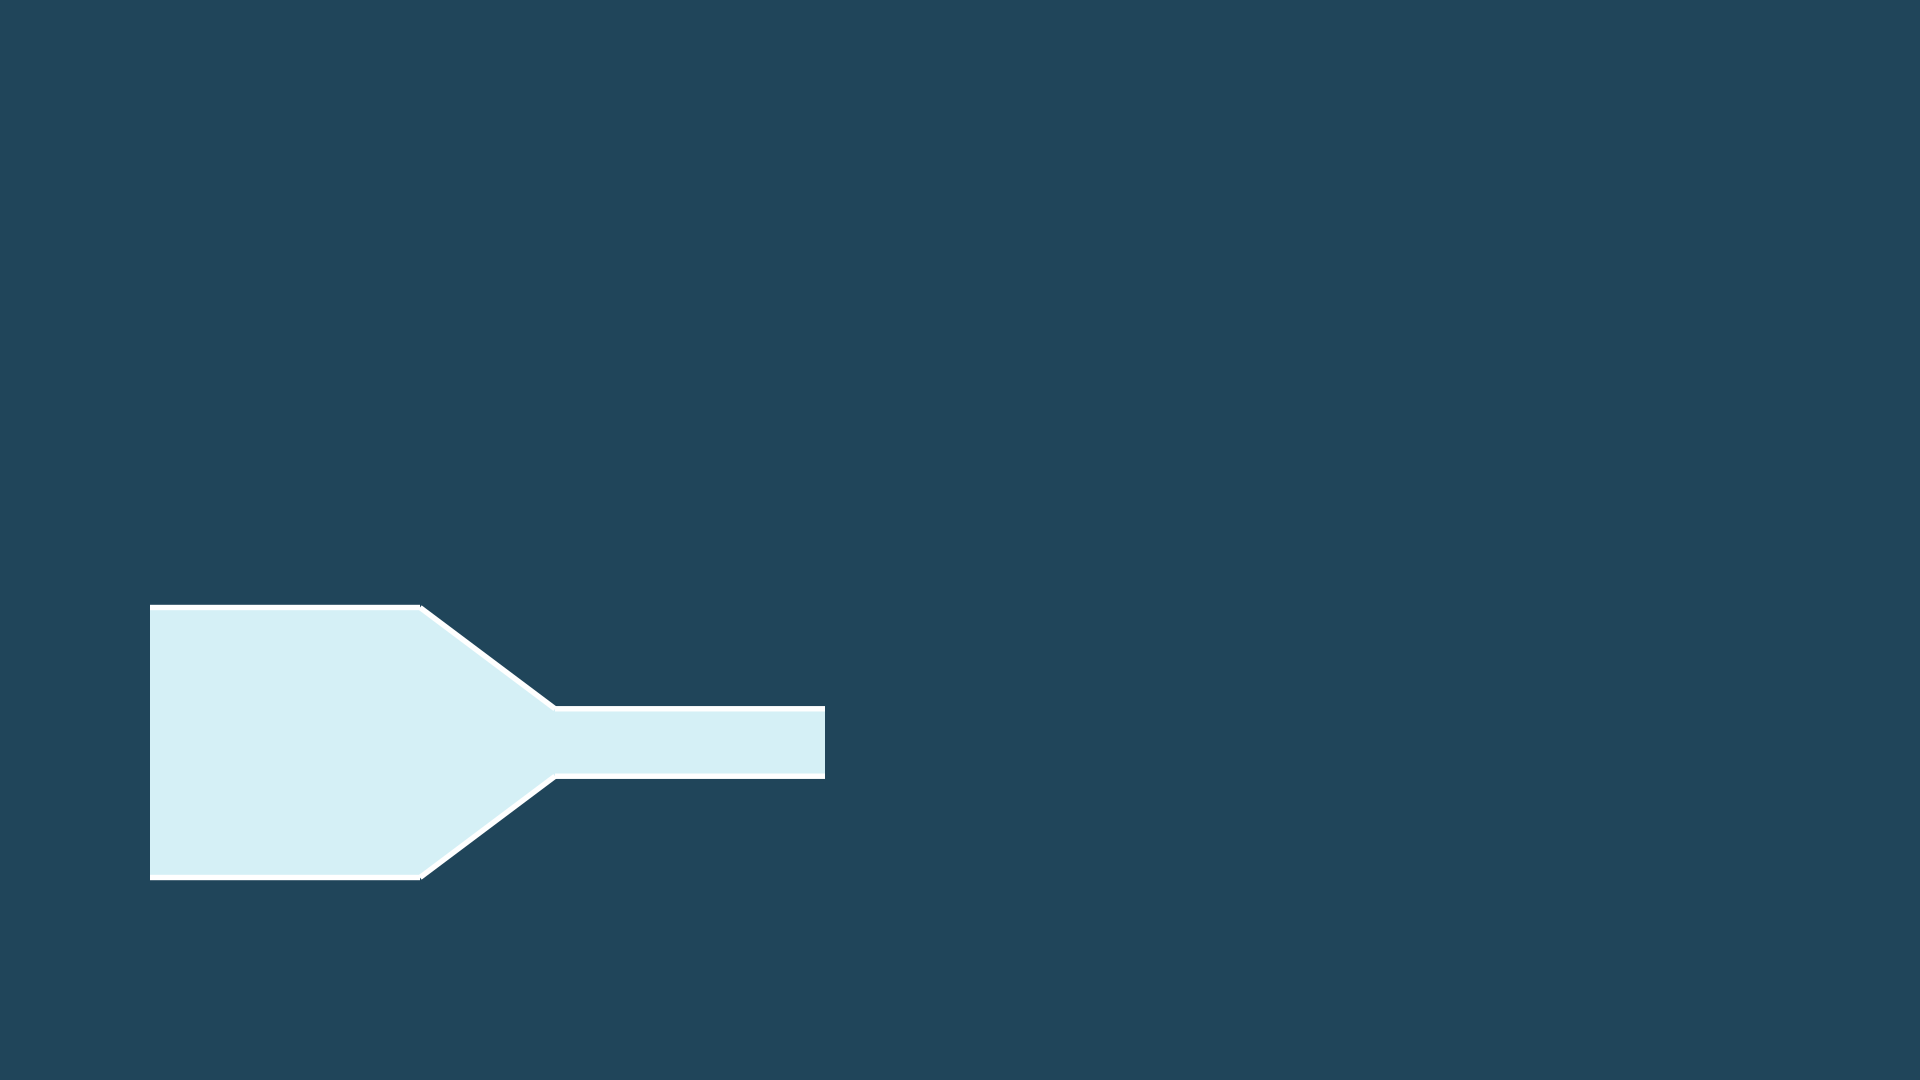

In [71]:
%%manim -qh --fps 60 $video_scene


class ndw_bernoulli_Scene(Scene):
    def construct(self):
        self.camera.background_color = background_color


        # bernoulli tube
        bernoulli_tube = BernoulliTube(tube_center = np.array([-2, -1.5, 0]))
        self.add(bernoulli_tube)